In [444]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import xgboost
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae
from keras.models import *
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.ensemble import AdaBoostRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold,cross_val_score
from sklearn.ensemble import StackingRegressor , BaggingRegressor

In [445]:
# Importation des jeux de données
train_df = pd.read_csv("certificatbigdata/train.csv",delimiter=",")
test_df = pd.read_csv("certificatbigdata/test.csv",delimiter=",")
store_df = pd.read_csv("certificatbigdata/store_metadata.csv",delimiter=",")

C:\Users\omabe\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [446]:
store_df

,id,store_type,assortment,promo_interval
0,1,c,a,NaN
1,2,a,a,"Jan,Apr,Jul,Oct"
2,3,a,a,"Jan,Apr,Jul,Oct"
3,4,c,c,NaN
4,5,a,a,NaN
...,...,...,...,...
1110,1111,a,a,"Jan,Apr,Jul,Oct"
1111,1112,c,c,NaN
1112,1113,a,c,NaN
1113,1114,a,c,NaN


# DATA CLEANING

In [447]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 813767 entries, 0 to 813766
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              813767 non-null  int64 
 1   date            813767 non-null  object
 2   customers       813767 non-null  int64 
 3   open            813767 non-null  int64 
 4   promo           813767 non-null  int64 
 5   state_holliday  813767 non-null  object
 6   school_holiday  813767 non-null  int64 
 7   y               813767 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 49.7+ MB


In [448]:
# On remarque que les données d'entrainement ne contiennent pas de valeurs NaN
train_df.isna().sum()

id                0
date              0
customers         0
open              0
promo             0
state_holliday    0
school_holiday    0
y                 0
dtype: int64

In [449]:
# Supprimer les données dupliquées
train_df = train_df.drop_duplicates()

In [450]:
print(f"unique open values :{train_df['open'].unique()}")
print(f"unique promo values :{train_df['promo'].unique()}")
print(f"unique state_holliday values :{train_df['state_holliday'].unique()}")
print(f"unique school_holiday values :{train_df['school_holiday'].unique()}")

unique open values :[0 1]
unique promo values :[0 1]
unique state_holliday values :['a' '0' 'b' 'c' 0]
unique school_holiday values :[1 0]


### state_holliday

In [451]:
# Observer les valeurs possibles de state_holliday
train_df['state_holliday'].value_counts()

0    761641
0     27335
a     16201
b      5322
c      3268
Name: state_holliday, dtype: int64

In [452]:
# Puisque state_holiday est binaire, on considère '0' , 0 => 0 et 'a','b','c' => 1
train_df['state_holliday'] = train_df['state_holliday'].apply(lambda x : 0 if str(x)=="0" else 1)
test_df['state_holliday'] = test_df['state_holliday'].apply(lambda x : 0 if str(x)=="0" else 1)

In [453]:
train_df['state_holliday'].value_counts()

0    788976
1     24791
Name: state_holliday, dtype: int64

### Open Var

In [454]:
# Voir si on dispose dans la base de données un magasin ouvert avec un volume des ventes positif
train_df[(train_df['open']==0) & (train_df['y']>0)]

,id,date,customers,open,promo,state_holliday,school_holiday,y


In [455]:
# Volume de ventes est toujours positif
train_df['y'].min()

0

In [456]:
test_df[(test_df['open']==0) & (test_df['y']>0)]

,id,date,customers,open,promo,state_holliday,school_holiday,y


In [457]:
test_df['y'].min()

0

In [458]:
# On déduit qu'on pourra nous en passer de l'input 'open' car quand ce n'est pas open la valeur y est nulle

#train_df = train_df.drop(columns=['open'])
#test_df = test_df.drop(columns=['open'])

In [459]:
# Vérifier si la variable Date ne prends pas des valeurs abérrantes

def chack_date(date):
  L = date.split('-')
  return len(L)==3 and len(L[0])==4 and len(L[1])==2 and len(L[2])==2
train_df['date'].apply(chack_date).value_counts()

True    813767
Name: date, dtype: int64

In [460]:
import seaborn as sns

<AxesSubplot:>

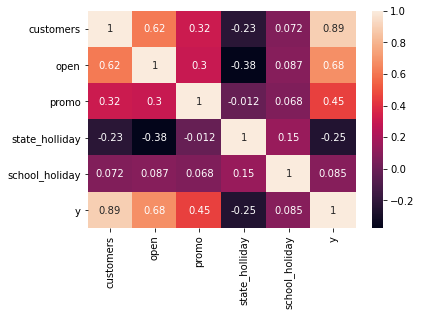

In [461]:
# Corrélation entre la variables; on remarque que le nombre de clients a une grande influence sur la nombre de ventes

sns.heatmap(train_df.drop(columns=['id']).corr(), annot=True)

In [462]:
# On remarque aussi qu'il y a une corrélation linéaire entre 'customers' et 'y'

#pd.plotting.scatter_matrix(train_df.drop(columns=['id','date']).sample(50000), alpha=0.2, figsize=(15,15))

## Store 

In [463]:
# Les valeurs possibles de 'store_type'

store_df['store_type'].value_counts()

a    602
d    348
c    148
b     17
Name: store_type, dtype: int64

In [464]:
# Les valeurs possibles de 'assortment'

store_df['assortment'].value_counts()

a    593
c    513
b      9
Name: assortment, dtype: int64

In [465]:
# Les valeurs possibles de 'promo_interval'

store_df['promo_interval'].value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: promo_interval, dtype: int64

In [466]:
train_df['promo'].value_counts()

0    503121
1    310646
Name: promo, dtype: int64

## Features

In [467]:
# Rajouter la variable y/customers

train_df['SalesPerCustomers'] = train_df['y'] / train_df['customers']

avg_store = train_df.groupby('id')[['y', 'customers', 'SalesPerCustomers']].mean()
avg_store.rename(columns=lambda x: 'Avg' + x, inplace=True)
store_df = pd.merge(avg_store.reset_index(), store_df, on='id')
store_df.head()

,id,Avgy,Avgcustomers,AvgSalesPerCustomers,store_type,assortment,promo_interval
0,1,3950.539370,467.883202,8.397500,c,a,NaN
1,2,4117.196078,485.605229,8.408104,a,a,"Jan,Apr,Jul,Oct"
2,3,5850.149194,630.470430,9.138877,a,a,"Jan,Apr,Jul,Oct"
3,4,8028.679245,1102.529650,7.243965,c,c,NaN
4,5,3873.781291,445.283267,8.609952,a,a,NaN


In [468]:
# Rajout de la variable dayofweek et dayofyear
train_df['day_of_week'] = pd.to_datetime(train_df['date']).dt.dayofweek
test_df['day_of_week'] = pd.to_datetime(test_df['date']).dt.dayofweek

train_df['day_of_year'] = pd.to_datetime(train_df['date']).dt.dayofyear
test_df['day_of_year'] = pd.to_datetime(test_df['date']).dt.dayofyear

train_df['week_of_year'] = pd.to_datetime(train_df['date']).dt.weekofyear
test_df['week_of_year'] = pd.to_datetime(test_df['date']).dt.weekofyear


okay = train_df.groupby(['id','day_of_week'])['y'].agg(['mean','median']).copy()
train_df = pd.merge(left = train_df , right = okay.reset_index(), on=['id','day_of_week'], how ='left')
test_df = pd.merge(left = test_df, right = okay.reset_index(),on=['id','day_of_week'], how ='left')

train_df.head()

<ipython-input-468-0b6ef44e10e9>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train_df['week_of_year'] = pd.to_datetime(train_df['date']).dt.weekofyear
<ipython-input-468-0b6ef44e10e9>:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  test_df['week_of_year'] = pd.to_datetime(test_df['date']).dt.weekofyear


,id,date,customers,open,promo,state_holliday,school_holiday,y,SalesPerCustomers,day_of_week,day_of_year,week_of_year,mean,median
0,1042,2013-01-01,0,0,0,1,1,0,NaN,1,1,1,4326.831776,4326.0
1,128,2013-01-01,0,0,0,1,1,0,NaN,1,1,1,7339.705357,6908.5
2,420,2013-01-01,0,0,0,1,1,0,NaN,1,1,1,4223.876543,4152.0
3,225,2013-01-01,0,0,0,1,1,0,NaN,1,1,1,5153.433962,5251.0
4,144,2013-01-01,0,0,0,1,1,0,NaN,1,1,1,7325.137500,7559.0


In [469]:
# Rajout de y(dayofyear-1)

train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
df = train_df.groupby('id').apply(lambda x: x.set_index('date').resample('1D').first())
df1 = df.groupby(level=0)['y'].apply(lambda x: x.shift().rolling(min_periods=1,window=1).mean()).reset_index(name='Value_Average_Past_7_days')
display(df1.isna().sum())
train_df = pd.merge(left = train_df , right = df1, on=['id','date'], how ='left')
test_df = pd.merge(left = test_df , right = df1, on=['id','date'], how ='left')

id                                0
date                              0
Value_Average_Past_7_days    237134
dtype: int64

In [470]:
#Ratio = y/customers byday_of_week
train_group = train_df.groupby(['id','day_of_week'])

ratio_df = pd.DataFrame({'ratio_by_day_of_week':train_group['y'].sum()/train_group['customers'].sum()})
customers_perday = pd.DataFrame({'CustomersPerDay':train_group['customers'].sum()})

train_df= pd.merge(left = train_df, right = ratio_df ,on=['id','day_of_week'], how ='left')
test_df = pd.merge(left = test_df, right = ratio_df,on=['id','day_of_week'], how ='left')

train_df= pd.merge(left = train_df, right = customers_perday ,on=['id','day_of_week'], how ='left')
test_df = pd.merge(left = test_df, right = customers_perday,on=['id','day_of_week'], how ='left')

#Rajout de app_y = ratio_by_dayofweek * customers
train_df['app_p'] = train_df['customers']*train_df['ratio_by_day_of_week']
test_df['app_p'] = test_df['customers']*test_df['ratio_by_day_of_week']

test_df

,id,date,customers,open,promo,state_holliday,school_holiday,y,day_of_week,day_of_year,week_of_year,mean,median,Value_Average_Past_7_days,ratio_by_day_of_week,CustomersPerDay,app_p
0,1105,2013-01-01,0,0,0,1,1,0,1,1,1,4385.796296,4044.0,NaN,8.886458,53302,0.000000
1,306,2013-01-01,0,0,0,1,1,0,1,1,1,4549.681818,4395.0,NaN,9.355798,42794,0.000000
2,1115,2013-01-01,0,0,0,1,1,0,1,1,1,5850.425926,5759.5,NaN,14.573775,43355,0.000000
3,506,2013-01-01,0,0,0,1,1,0,1,1,1,7642.980198,7331.0,NaN,9.022218,85560,0.000000
4,877,2013-01-01,0,0,0,1,1,0,1,1,1,6685.594828,6695.0,NaN,7.372790,105188,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203437,728,2015-07-31,542,1,1,0,1,0,4,212,31,5339.584071,5585.0,NaN,11.468789,52610,6216.083748
203438,323,2015-07-31,716,1,1,0,1,0,4,212,31,7087.971963,7420.0,NaN,11.870420,63891,8499.220673
203439,912,2015-07-31,806,1,1,0,1,0,4,212,31,5383.701754,5387.0,NaN,7.555701,81229,6089.894644
203440,276,2015-07-31,575,1,1,0,1,0,4,212,31,4178.513043,4456.0,NaN,7.808782,61537,4490.049482


In [471]:
# Remove points with 0 Sales
# Set Open = 0 when Sales = 0 OR Customers = 0
# train_df.loc[ (train_df['customers']==0) | (train_df['y']==0) , 'open' ] = 0
# train_df = train_df[train_df['open'] == 1]

# Building features

In [472]:
pd.set_option('display.max_columns', None)

In [473]:
def build_features(train = train_df, store = store_df):
    # Convert string types into integers
    store['store_type'] = store['store_type'].astype('category').cat.codes
    store['assortment'] = store['assortment'].astype('category').cat.codes
    store['promo_interval'] = store['promo_interval'].astype('category').cat.codes
    train["state_holliday"] = train["state_holliday"].astype('category').cat.codes
    
    merged = pd.merge(train, store, on='id', how='left')
    
    merged['Year'] = pd.to_datetime(merged['date']).dt.year
    merged['Month'] = pd.to_datetime(merged['date']).dt.month
    merged['Day'] = pd.to_datetime(merged['date']).dt.day
    merged['Week'] = pd.to_datetime(merged['date']).dt.week
    
    # remove NaNs
    NaN_replace = 0
    merged.fillna(NaN_replace, inplace=True)

    return merged

med_store = train_df.groupby('id')[['y', 'customers', 'SalesPerCustomers']].median()
med_store.rename(columns=lambda x: 'Med' + x, inplace=True)

store_df = pd.merge(med_store.reset_index(), store_df, on='id')
features = build_features(train_df, store_df)
features

<ipython-input-473-a12169c1d938>:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  merged['Week'] = pd.to_datetime(merged['date']).dt.week


,id,date,customers,open,promo,state_holliday,school_holiday,y,SalesPerCustomers,day_of_week,day_of_year,week_of_year,mean,median,Value_Average_Past_7_days,ratio_by_day_of_week,CustomersPerDay,app_p,Medy,Medcustomers,MedSalesPerCustomers,Avgy,Avgcustomers,AvgSalesPerCustomers,store_type,assortment,promo_interval,Year,Month,Day,Week
0,1042,2013-01-01,0,0,0,1,1,0,0.000000,1,1,1,4326.831776,4326.0,0.0,7.412280,62460,0.000000,3627.0,512.0,7.346963,3363.957839,446.072464,7.443203,0,0,0,2013,1,1,1
1,128,2013-01-01,0,0,0,1,1,0,0.000000,1,1,1,7339.705357,6908.5,0.0,12.703947,64708,0.000000,6671.5,556.0,12.276435,6176.957143,492.961039,12.373707,3,2,1,2013,1,1,1
2,420,2013-01-01,0,0,0,1,1,0,0.000000,1,1,1,4223.876543,4152.0,0.0,11.001093,31100,0.000000,4156.5,382.0,11.209468,3769.974832,334.003356,11.193422,3,2,1,2013,1,1,1
3,225,2013-01-01,0,0,0,1,1,0,0.000000,1,1,1,5153.433962,5251.0,0.0,9.484903,57593,0.000000,4565.0,519.0,9.164230,4367.282993,467.165986,9.247951,3,0,-1,2013,1,1,1
4,144,2013-01-01,0,0,0,1,1,0,0.000000,1,1,1,7325.137500,7559.0,0.0,10.635794,55098,0.000000,7030.0,691.0,10.433333,6343.254576,599.552413,10.508401,0,2,-1,2013,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813762,757,2015-07-31,684,1,1,0,1,9343,13.659357,4,212,31,5783.644231,6016.0,7813.0,11.625640,51739,7951.937919,5527.0,501.0,11.425388,5095.916777,439.859974,11.482440,0,2,-1,2015,7,31,31
813763,796,2015-07-31,769,1,1,0,1,8913,11.590377,4,212,31,6867.689320,7083.0,0.0,10.584014,66834,8139.106862,6426.0,645.0,10.737490,5960.280702,548.217274,10.767563,0,2,-1,2015,7,31,31
813764,230,2015-07-31,1091,1,1,0,1,10988,10.071494,4,212,31,7424.207207,7456.0,0.0,8.097225,101774,8834.072720,6948.0,896.0,7.904656,6305.500666,783.585885,7.973675,3,2,-1,2015,7,31,31
813765,387,2015-07-31,1402,1,1,0,1,14533,10.365906,4,212,31,8825.346154,9167.0,10764.0,7.753565,118376,10870.498006,7784.0,1094.0,7.587732,7561.992011,963.762983,7.727806,2,0,2,2015,7,31,31


In [474]:
#Remove outliers

# def reject_outliers(df,col_name, m=2.6):
#     return df[ (df[col_name] - df[col_name].mean()).abs() < m * df[col_name].std()]

# features = pd.concat([reject_outliers(df,'SalesPerCustomers') for ID,df in features.groupby(['id'])])
# features = features.sort_index()

# features

In [475]:
X = [
    'id', 
    'customers',
    'promo',
    #'promo_interval',
    #'PromoInter',
    
    'school_holiday',
    'state_holliday',
    'store_type',
    'assortment',
    
    'Avgy',
    'Avgcustomers',
    'AvgSalesPerCustomers',
    
    'Medy',
    'Medcustomers',
    'MedSalesPerCustomers',

    'day_of_week',
    'day_of_year',
    'week_of_year',
    
    'Week',
    'Day',
    'Month',
    'Year',
    
    'ratio_by_day_of_week',
    'app_p',
    'CustomersPerDay',

    #'Value_Average_Past_7_days'
]

X_train, X_valid, y_train, y_valid = train_test_split(
    features[X], features['y'], test_size=0.15, random_state=42)

X1 , y1 = features[X].copy(), features['y'].copy()

In [476]:
#Scaling
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_valid = scaler.transform(X_valid)

In [477]:
# Print input/target format 
print(f'Input shape  : {X1.shape}')
print(f'Target shape : {y1.shape}')
display(X1)

Input shape  : (813767, 22)
Target shape : (813767,)


,id,customers,promo,school_holiday,state_holliday,store_type,assortment,Avgy,Avgcustomers,AvgSalesPerCustomers,Medy,Medcustomers,MedSalesPerCustomers,day_of_week,day_of_year,week_of_year,Week,Day,Month,Year,app_p,CustomersPerDay
0,1042,0,0,1,1,0,0,3363.957839,446.072464,7.443203,3627.0,512.0,7.346963,1,1,1,1,1,1,2013,0.000000,62460
1,128,0,0,1,1,3,2,6176.957143,492.961039,12.373707,6671.5,556.0,12.276435,1,1,1,1,1,1,2013,0.000000,64708
2,420,0,0,1,1,3,2,3769.974832,334.003356,11.193422,4156.5,382.0,11.209468,1,1,1,1,1,1,2013,0.000000,31100
3,225,0,0,1,1,3,0,4367.282993,467.165986,9.247951,4565.0,519.0,9.164230,1,1,1,1,1,1,2013,0.000000,57593
4,144,0,0,1,1,0,2,6343.254576,599.552413,10.508401,7030.0,691.0,10.433333,1,1,1,1,1,1,2013,0.000000,55098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813762,757,684,1,1,0,0,2,5095.916777,439.859974,11.482440,5527.0,501.0,11.425388,4,212,31,31,31,7,2015,7951.937919,51739
813763,796,769,1,1,0,0,2,5960.280702,548.217274,10.767563,6426.0,645.0,10.737490,4,212,31,31,31,7,2015,8139.106862,66834
813764,230,1091,1,1,0,3,2,6305.500666,783.585885,7.973675,6948.0,896.0,7.904656,4,212,31,31,31,7,2015,8834.072720,101774
813765,387,1402,1,1,0,2,0,7561.992011,963.762983,7.727806,7784.0,1094.0,7.587732,4,212,31,31,31,7,2015,10870.498006,118376


In [478]:
# Print Data size
print(f'Train size : {X_train.shape[0]}')
print(f'Validation size : {X_valid.shape[0]}')
#print(f'Test size : {X_test.shape[0]}')

Train size : 691701
Validation size : 122066


In [479]:
# Vérifier si X1 et test_df_new ne contient au final que des valeurs numériques

X1.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())
# test_df_new.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())

id                      True
customers               True
promo                   True
school_holiday          True
state_holliday          True
store_type              True
assortment              True
Avgy                    True
Avgcustomers            True
AvgSalesPerCustomers    True
Medy                    True
Medcustomers            True
MedSalesPerCustomers    True
day_of_week             True
day_of_year             True
week_of_year            True
Week                    True
Day                     True
Month                   True
Year                    True
app_p                   True
CustomersPerDay         True
dtype: bool

## Remove Outliers

In [480]:
# #remove outliers
# train_nozero['ratio'] = train_nozero['y']/train_nozero['customers']
# def reject_outliers(df,col_name, m=1):
#     return df[ (df[col_name] - df[col_name].mean()).abs() < m * df[col_name].std()]

# train_nozero = pd.concat([reject_outliers(df,'ratio') for ID,df in train_nozero.groupby(['id'])])

# Models

## XGBoost

In [ ]:
xgb = XGBRegressor(
    n_estimators = 140,
    eta = 0.1,
    max_depth = 17,
    min_child_weight = 4,
    subsample = 0.8,
    colsample_bytree = 0.8,
    tree_method = 'exact',
    reg_alpha = 0.06,
    random_state = 1043)

In [ ]:
xgb.fit(X1, y1,eval_metric = 'mae')

In [ ]:
features = build_features(test_df, store_df)

test_preds = xgb.predict(features[X])

test_preds

In [ ]:
xgb.fit(X_train[X], y_train, 
                 eval_set = [(X_train[X], y_train), (X_valid[X], y_valid)],
                 eval_metric = 'mae',
                 early_stopping_rounds = 200
                )

In [ ]:
from sklearn import model_selection
def evaluate_model(model, X, y):
    cv = model_selection.KFold(n_splits=5)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, error_score='raise',verbose=1)
    return scores

In [ ]:
evaluate_model(xgb,X1,y1)

## Random Forest

In [ ]:
rdmForest = RandomForestRegressor(n_estimators=300, max_depth=17, n_jobs=-1, random_state=1043)

rdmForest.fit(X1,y1)

In [ ]:
features = build_features(test_df, store_df)

test_preds = rdmForest.predict(features[X])

test_preds

In [ ]:
mae(y1,model.predict(X1))

## Decision Tree Regressor

In [ ]:
desision_tree = DecisionTreeRegressor(splitter='random', max_depth=16, random_state=21)

desision_tree.fit(X1, y1)

In [ ]:
features = build_features(test_df, store_df)

test_preds = desision_tree.predict(features[X])

test_preds

## LightGBM

In [481]:
import lightgbm as lgb
base_lgb_model = lgb.LGBMRegressor(num_leaves=65,
                               n_estimators=4800, 
                               max_depth=15,  
                               min_child_weight=0.008,
                               learning_rate=0.12,
                               subsample=0.8,
                               colsample_bytree=0.8,
                               reg_alpha=0.1,
                               reg_lambda=1,
                            )



In [437]:
base_lgb_model.fit(X_train[X], y_train, 
                 eval_set = [(X_train[X], y_train), (X_valid[X], y_valid)],
                 eval_metric = 'mae',
                 early_stopping_rounds = 200
                )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3741
[LightGBM] [Info] Number of data points in the train set: 691701, number of used features: 25
[LightGBM] [Info] Start training from score 5775.228055
[1]	valid_0's l1: 2547.8	valid_0's l2: 1.15427e+07	valid_1's l1: 2542.66	valid_1's l2: 1.151e+07
Training until validation scores don't improve for 200 rounds
[2]	valid_0's l1: 2249.05	valid_0's l2: 8.99987e+06	valid_1's l1: 2244.78	valid_1's l2: 8.97694e+06
[3]	valid_0's l1: 2008.51	valid_0's l2: 7.18075e+06	valid_1's l1: 2005.36	valid_1's l2: 7.16384e+06
[4]	valid_0's l1: 1776.29	valid_0's l2: 5.62038e+06	valid_1's l1: 1773.82	valid_1's l2: 5.60955e+06
[5]	valid_0's l1: 1572.84	valid_0's l2: 4.4111e+06	valid_1's l1: 1570.85	valid_1's l2: 4.40564e+06
[6]	valid_0's l1: 1399.38	valid_0's l2: 3.50464e+06	valid_1's l1: 1397.93	valid_1's l2: 3.501

[89]	valid_0's l1: 230.856	valid_0's l2: 129911	valid_1's l1: 233.797	valid_1's l2: 139965
[90]	valid_0's l1: 230.781	valid_0's l2: 129701	valid_1's l1: 233.741	valid_1's l2: 139821
[91]	valid_0's l1: 230.67	valid_0's l2: 129519	valid_1's l1: 233.662	valid_1's l2: 139691
[92]	valid_0's l1: 230.512	valid_0's l2: 129357	valid_1's l1: 233.511	valid_1's l2: 139543
[93]	valid_0's l1: 230.44	valid_0's l2: 129223	valid_1's l1: 233.455	valid_1's l2: 139435
[94]	valid_0's l1: 230.382	valid_0's l2: 129053	valid_1's l1: 233.42	valid_1's l2: 139292
[95]	valid_0's l1: 230.298	valid_0's l2: 128908	valid_1's l1: 233.362	valid_1's l2: 139177
[96]	valid_0's l1: 230.256	valid_0's l2: 128785	valid_1's l1: 233.352	valid_1's l2: 139111
[97]	valid_0's l1: 230.136	valid_0's l2: 128520	valid_1's l1: 233.249	valid_1's l2: 138918
[98]	valid_0's l1: 230.073	valid_0's l2: 128427	valid_1's l1: 233.198	valid_1's l2: 138847
[99]	valid_0's l1: 229.918	valid_0's l2: 128244	valid_1's l1: 233.047	valid_1's l2: 138683
[1

[179]	valid_0's l1: 223.782	valid_0's l2: 118372	valid_1's l1: 228.697	valid_1's l2: 131646
[180]	valid_0's l1: 223.764	valid_0's l2: 118324	valid_1's l1: 228.688	valid_1's l2: 131625
[181]	valid_0's l1: 223.715	valid_0's l2: 118223	valid_1's l1: 228.668	valid_1's l2: 131578
[182]	valid_0's l1: 223.659	valid_0's l2: 118147	valid_1's l1: 228.644	valid_1's l2: 131531
[183]	valid_0's l1: 223.608	valid_0's l2: 118049	valid_1's l1: 228.608	valid_1's l2: 131458
[184]	valid_0's l1: 223.58	valid_0's l2: 117987	valid_1's l1: 228.606	valid_1's l2: 131449
[185]	valid_0's l1: 223.521	valid_0's l2: 117874	valid_1's l1: 228.578	valid_1's l2: 131414
[186]	valid_0's l1: 223.465	valid_0's l2: 117818	valid_1's l1: 228.546	valid_1's l2: 131381
[187]	valid_0's l1: 223.43	valid_0's l2: 117779	valid_1's l1: 228.52	valid_1's l2: 131354
[188]	valid_0's l1: 223.392	valid_0's l2: 117690	valid_1's l1: 228.516	valid_1's l2: 131325
[189]	valid_0's l1: 223.37	valid_0's l2: 117638	valid_1's l1: 228.514	valid_1's l2:

[270]	valid_0's l1: 218.874	valid_0's l2: 111200	valid_1's l1: 225.532	valid_1's l2: 127083
[271]	valid_0's l1: 218.837	valid_0's l2: 111149	valid_1's l1: 225.512	valid_1's l2: 127070
[272]	valid_0's l1: 218.788	valid_0's l2: 111085	valid_1's l1: 225.481	valid_1's l2: 127034
[273]	valid_0's l1: 218.738	valid_0's l2: 111029	valid_1's l1: 225.447	valid_1's l2: 126992
[274]	valid_0's l1: 218.712	valid_0's l2: 110973	valid_1's l1: 225.434	valid_1's l2: 126955
[275]	valid_0's l1: 218.677	valid_0's l2: 110932	valid_1's l1: 225.429	valid_1's l2: 126948
[276]	valid_0's l1: 218.642	valid_0's l2: 110885	valid_1's l1: 225.408	valid_1's l2: 126926
[277]	valid_0's l1: 218.584	valid_0's l2: 110818	valid_1's l1: 225.379	valid_1's l2: 126882
[278]	valid_0's l1: 218.497	valid_0's l2: 110602	valid_1's l1: 225.321	valid_1's l2: 126857
[279]	valid_0's l1: 218.451	valid_0's l2: 110505	valid_1's l1: 225.282	valid_1's l2: 126812
[280]	valid_0's l1: 218.416	valid_0's l2: 110460	valid_1's l1: 225.27	valid_1's 

[365]	valid_0's l1: 215.331	valid_0's l2: 106216	valid_1's l1: 223.58	valid_1's l2: 124467
[366]	valid_0's l1: 215.31	valid_0's l2: 106185	valid_1's l1: 223.578	valid_1's l2: 124468
[367]	valid_0's l1: 215.267	valid_0's l2: 106141	valid_1's l1: 223.545	valid_1's l2: 124434
[368]	valid_0's l1: 215.247	valid_0's l2: 106124	valid_1's l1: 223.543	valid_1's l2: 124432
[369]	valid_0's l1: 215.224	valid_0's l2: 106110	valid_1's l1: 223.527	valid_1's l2: 124422
[370]	valid_0's l1: 215.196	valid_0's l2: 106077	valid_1's l1: 223.515	valid_1's l2: 124409
[371]	valid_0's l1: 215.16	valid_0's l2: 106025	valid_1's l1: 223.493	valid_1's l2: 124381
[372]	valid_0's l1: 215.109	valid_0's l2: 105972	valid_1's l1: 223.462	valid_1's l2: 124350
[373]	valid_0's l1: 215.073	valid_0's l2: 105918	valid_1's l1: 223.439	valid_1's l2: 124301
[374]	valid_0's l1: 215.031	valid_0's l2: 105875	valid_1's l1: 223.412	valid_1's l2: 124268
[375]	valid_0's l1: 215.015	valid_0's l2: 105840	valid_1's l1: 223.405	valid_1's l2

[545]	valid_0's l1: 209.317	valid_0's l2: 98204.5	valid_1's l1: 220.485	valid_1's l2: 120505
[546]	valid_0's l1: 209.292	valid_0's l2: 98175.9	valid_1's l1: 220.475	valid_1's l2: 120489
[547]	valid_0's l1: 209.244	valid_0's l2: 98144	valid_1's l1: 220.444	valid_1's l2: 120464
[548]	valid_0's l1: 209.221	valid_0's l2: 98111.9	valid_1's l1: 220.435	valid_1's l2: 120459
[549]	valid_0's l1: 209.197	valid_0's l2: 98086.9	valid_1's l1: 220.417	valid_1's l2: 120449
[550]	valid_0's l1: 209.158	valid_0's l2: 98051.6	valid_1's l1: 220.392	valid_1's l2: 120432
[551]	valid_0's l1: 209.13	valid_0's l2: 98010.8	valid_1's l1: 220.382	valid_1's l2: 120417
[552]	valid_0's l1: 209.107	valid_0's l2: 97989.2	valid_1's l1: 220.378	valid_1's l2: 120412
[553]	valid_0's l1: 209.087	valid_0's l2: 97963.9	valid_1's l1: 220.375	valid_1's l2: 120408
[554]	valid_0's l1: 209.062	valid_0's l2: 97939.9	valid_1's l1: 220.366	valid_1's l2: 120398
[555]	valid_0's l1: 209.041	valid_0's l2: 97903.7	valid_1's l1: 220.363	v

[635]	valid_0's l1: 206.877	valid_0's l2: 95369.7	valid_1's l1: 219.341	valid_1's l2: 119363
[636]	valid_0's l1: 206.855	valid_0's l2: 95344.5	valid_1's l1: 219.331	valid_1's l2: 119354
[637]	valid_0's l1: 206.83	valid_0's l2: 95322.3	valid_1's l1: 219.321	valid_1's l2: 119351
[638]	valid_0's l1: 206.801	valid_0's l2: 95277.2	valid_1's l1: 219.314	valid_1's l2: 119334
[639]	valid_0's l1: 206.782	valid_0's l2: 95248.8	valid_1's l1: 219.31	valid_1's l2: 119329
[640]	valid_0's l1: 206.743	valid_0's l2: 95202.9	valid_1's l1: 219.285	valid_1's l2: 119304
[641]	valid_0's l1: 206.719	valid_0's l2: 95175.2	valid_1's l1: 219.284	valid_1's l2: 119301
[642]	valid_0's l1: 206.71	valid_0's l2: 95157.2	valid_1's l1: 219.286	valid_1's l2: 119304
[643]	valid_0's l1: 206.681	valid_0's l2: 95129	valid_1's l1: 219.271	valid_1's l2: 119291
[644]	valid_0's l1: 206.66	valid_0's l2: 95102.7	valid_1's l1: 219.265	valid_1's l2: 119282
[645]	valid_0's l1: 206.632	valid_0's l2: 95068.9	valid_1's l1: 219.249	vali

[729]	valid_0's l1: 204.634	valid_0's l2: 92688.2	valid_1's l1: 218.464	valid_1's l2: 118407
[730]	valid_0's l1: 204.616	valid_0's l2: 92663.6	valid_1's l1: 218.463	valid_1's l2: 118402
[731]	valid_0's l1: 204.563	valid_0's l2: 92596.4	valid_1's l1: 218.418	valid_1's l2: 118367
[732]	valid_0's l1: 204.518	valid_0's l2: 92556.1	valid_1's l1: 218.391	valid_1's l2: 118351
[733]	valid_0's l1: 204.496	valid_0's l2: 92528.1	valid_1's l1: 218.381	valid_1's l2: 118342
[734]	valid_0's l1: 204.477	valid_0's l2: 92507.3	valid_1's l1: 218.384	valid_1's l2: 118344
[735]	valid_0's l1: 204.46	valid_0's l2: 92489.7	valid_1's l1: 218.377	valid_1's l2: 118336
[736]	valid_0's l1: 204.43	valid_0's l2: 92443.6	valid_1's l1: 218.365	valid_1's l2: 118316
[737]	valid_0's l1: 204.408	valid_0's l2: 92412.3	valid_1's l1: 218.357	valid_1's l2: 118307
[738]	valid_0's l1: 204.383	valid_0's l2: 92374.5	valid_1's l1: 218.355	valid_1's l2: 118316
[739]	valid_0's l1: 204.333	valid_0's l2: 92315.6	valid_1's l1: 218.321	

[824]	valid_0's l1: 202.384	valid_0's l2: 90178.1	valid_1's l1: 217.555	valid_1's l2: 117525
[825]	valid_0's l1: 202.369	valid_0's l2: 90159.8	valid_1's l1: 217.551	valid_1's l2: 117518
[826]	valid_0's l1: 202.357	valid_0's l2: 90141.4	valid_1's l1: 217.555	valid_1's l2: 117521
[827]	valid_0's l1: 202.338	valid_0's l2: 90113.8	valid_1's l1: 217.541	valid_1's l2: 117512
[828]	valid_0's l1: 202.331	valid_0's l2: 90101.3	valid_1's l1: 217.537	valid_1's l2: 117503
[829]	valid_0's l1: 202.316	valid_0's l2: 90081	valid_1's l1: 217.537	valid_1's l2: 117503
[830]	valid_0's l1: 202.303	valid_0's l2: 90065.1	valid_1's l1: 217.535	valid_1's l2: 117500
[831]	valid_0's l1: 202.292	valid_0's l2: 90048.7	valid_1's l1: 217.525	valid_1's l2: 117490
[832]	valid_0's l1: 202.275	valid_0's l2: 90025.2	valid_1's l1: 217.52	valid_1's l2: 117463
[833]	valid_0's l1: 202.255	valid_0's l2: 90005.4	valid_1's l1: 217.52	valid_1's l2: 117465
[834]	valid_0's l1: 202.224	valid_0's l2: 89973.4	valid_1's l1: 217.51	val

[1004]	valid_0's l1: 198.809	valid_0's l2: 86250	valid_1's l1: 216.378	valid_1's l2: 116172
[1005]	valid_0's l1: 198.794	valid_0's l2: 86234.9	valid_1's l1: 216.376	valid_1's l2: 116170
[1006]	valid_0's l1: 198.774	valid_0's l2: 86215.6	valid_1's l1: 216.373	valid_1's l2: 116166
[1007]	valid_0's l1: 198.765	valid_0's l2: 86209.5	valid_1's l1: 216.374	valid_1's l2: 116167
[1008]	valid_0's l1: 198.75	valid_0's l2: 86191.7	valid_1's l1: 216.37	valid_1's l2: 116158
[1009]	valid_0's l1: 198.736	valid_0's l2: 86181.2	valid_1's l1: 216.369	valid_1's l2: 116159
[1010]	valid_0's l1: 198.718	valid_0's l2: 86165.7	valid_1's l1: 216.373	valid_1's l2: 116161
[1011]	valid_0's l1: 198.705	valid_0's l2: 86154.6	valid_1's l1: 216.373	valid_1's l2: 116159
[1012]	valid_0's l1: 198.696	valid_0's l2: 86141.5	valid_1's l1: 216.368	valid_1's l2: 116145
[1013]	valid_0's l1: 198.686	valid_0's l2: 86127.4	valid_1's l1: 216.373	valid_1's l2: 116158
[1014]	valid_0's l1: 198.68	valid_0's l2: 86116.3	valid_1's l1: 

[1098]	valid_0's l1: 197.098	valid_0's l2: 84561.4	valid_1's l1: 215.861	valid_1's l2: 115705
[1099]	valid_0's l1: 197.081	valid_0's l2: 84546.8	valid_1's l1: 215.862	valid_1's l2: 115705
[1100]	valid_0's l1: 197.061	valid_0's l2: 84526.4	valid_1's l1: 215.857	valid_1's l2: 115699
[1101]	valid_0's l1: 197.042	valid_0's l2: 84506.6	valid_1's l1: 215.857	valid_1's l2: 115697
[1102]	valid_0's l1: 197.016	valid_0's l2: 84478.6	valid_1's l1: 215.849	valid_1's l2: 115689
[1103]	valid_0's l1: 196.997	valid_0's l2: 84460.3	valid_1's l1: 215.843	valid_1's l2: 115685
[1104]	valid_0's l1: 196.979	valid_0's l2: 84440.8	valid_1's l1: 215.839	valid_1's l2: 115681
[1105]	valid_0's l1: 196.947	valid_0's l2: 84432.1	valid_1's l1: 215.816	valid_1's l2: 115677
[1106]	valid_0's l1: 196.928	valid_0's l2: 84414.5	valid_1's l1: 215.808	valid_1's l2: 115671
[1107]	valid_0's l1: 196.911	valid_0's l2: 84400	valid_1's l1: 215.807	valid_1's l2: 115672
[1108]	valid_0's l1: 196.895	valid_0's l2: 84388	valid_1's l1:

[1186]	valid_0's l1: 195.502	valid_0's l2: 83021.8	valid_1's l1: 215.34	valid_1's l2: 115246
[1187]	valid_0's l1: 195.478	valid_0's l2: 82996.1	valid_1's l1: 215.322	valid_1's l2: 115226
[1188]	valid_0's l1: 195.463	valid_0's l2: 82980.6	valid_1's l1: 215.322	valid_1's l2: 115227
[1189]	valid_0's l1: 195.444	valid_0's l2: 82966.9	valid_1's l1: 215.319	valid_1's l2: 115221
[1190]	valid_0's l1: 195.424	valid_0's l2: 82946.8	valid_1's l1: 215.317	valid_1's l2: 115220
[1191]	valid_0's l1: 195.407	valid_0's l2: 82929.9	valid_1's l1: 215.311	valid_1's l2: 115216
[1192]	valid_0's l1: 195.39	valid_0's l2: 82916.5	valid_1's l1: 215.311	valid_1's l2: 115217
[1193]	valid_0's l1: 195.376	valid_0's l2: 82905.3	valid_1's l1: 215.308	valid_1's l2: 115213
[1194]	valid_0's l1: 195.348	valid_0's l2: 82878	valid_1's l1: 215.305	valid_1's l2: 115211
[1195]	valid_0's l1: 195.333	valid_0's l2: 82865.5	valid_1's l1: 215.303	valid_1's l2: 115209
[1196]	valid_0's l1: 195.315	valid_0's l2: 82850.3	valid_1's l1:

[1275]	valid_0's l1: 194	valid_0's l2: 81543.1	valid_1's l1: 215.037	valid_1's l2: 114929
[1276]	valid_0's l1: 193.987	valid_0's l2: 81533.1	valid_1's l1: 215.031	valid_1's l2: 114926
[1277]	valid_0's l1: 193.966	valid_0's l2: 81511.4	valid_1's l1: 215.025	valid_1's l2: 114918
[1278]	valid_0's l1: 193.949	valid_0's l2: 81492.2	valid_1's l1: 215.026	valid_1's l2: 114916
[1279]	valid_0's l1: 193.927	valid_0's l2: 81474.2	valid_1's l1: 215.016	valid_1's l2: 114908
[1280]	valid_0's l1: 193.912	valid_0's l2: 81460.1	valid_1's l1: 215.017	valid_1's l2: 114909
[1281]	valid_0's l1: 193.902	valid_0's l2: 81450	valid_1's l1: 215.014	valid_1's l2: 114903
[1282]	valid_0's l1: 193.883	valid_0's l2: 81435.5	valid_1's l1: 215.008	valid_1's l2: 114898
[1283]	valid_0's l1: 193.856	valid_0's l2: 81414	valid_1's l1: 215	valid_1's l2: 114890
[1284]	valid_0's l1: 193.844	valid_0's l2: 81403	valid_1's l1: 214.997	valid_1's l2: 114887
[1285]	valid_0's l1: 193.832	valid_0's l2: 81390.5	valid_1's l1: 214.991	v

[1364]	valid_0's l1: 192.579	valid_0's l2: 80175.1	valid_1's l1: 214.674	valid_1's l2: 114612
[1365]	valid_0's l1: 192.565	valid_0's l2: 80162.8	valid_1's l1: 214.673	valid_1's l2: 114610
[1366]	valid_0's l1: 192.557	valid_0's l2: 80154.7	valid_1's l1: 214.675	valid_1's l2: 114611
[1367]	valid_0's l1: 192.548	valid_0's l2: 80149.3	valid_1's l1: 214.674	valid_1's l2: 114610
[1368]	valid_0's l1: 192.537	valid_0's l2: 80138.5	valid_1's l1: 214.672	valid_1's l2: 114607
[1369]	valid_0's l1: 192.528	valid_0's l2: 80131	valid_1's l1: 214.671	valid_1's l2: 114606
[1370]	valid_0's l1: 192.515	valid_0's l2: 80120.3	valid_1's l1: 214.67	valid_1's l2: 114602
[1371]	valid_0's l1: 192.506	valid_0's l2: 80114.1	valid_1's l1: 214.667	valid_1's l2: 114598
[1372]	valid_0's l1: 192.491	valid_0's l2: 80101.1	valid_1's l1: 214.668	valid_1's l2: 114597
[1373]	valid_0's l1: 192.484	valid_0's l2: 80096.2	valid_1's l1: 214.668	valid_1's l2: 114597
[1374]	valid_0's l1: 192.469	valid_0's l2: 80084.6	valid_1's l1

[1453]	valid_0's l1: 191.284	valid_0's l2: 78889.1	valid_1's l1: 214.419	valid_1's l2: 114235
[1454]	valid_0's l1: 191.269	valid_0's l2: 78873	valid_1's l1: 214.418	valid_1's l2: 114232
[1455]	valid_0's l1: 191.258	valid_0's l2: 78864.5	valid_1's l1: 214.417	valid_1's l2: 114231
[1456]	valid_0's l1: 191.245	valid_0's l2: 78853.1	valid_1's l1: 214.42	valid_1's l2: 114237
[1457]	valid_0's l1: 191.23	valid_0's l2: 78840.3	valid_1's l1: 214.417	valid_1's l2: 114237
[1458]	valid_0's l1: 191.214	valid_0's l2: 78826.6	valid_1's l1: 214.412	valid_1's l2: 114231
[1459]	valid_0's l1: 191.2	valid_0's l2: 78813.5	valid_1's l1: 214.413	valid_1's l2: 114235
[1460]	valid_0's l1: 191.182	valid_0's l2: 78794.1	valid_1's l1: 214.408	valid_1's l2: 114234
[1461]	valid_0's l1: 191.165	valid_0's l2: 78778.5	valid_1's l1: 214.409	valid_1's l2: 114236
[1462]	valid_0's l1: 191.151	valid_0's l2: 78761.8	valid_1's l1: 214.412	valid_1's l2: 114237
[1463]	valid_0's l1: 191.117	valid_0's l2: 78723.4	valid_1's l1: 2

[1545]	valid_0's l1: 189.902	valid_0's l2: 77635.5	valid_1's l1: 214.121	valid_1's l2: 113988
[1546]	valid_0's l1: 189.898	valid_0's l2: 77629.6	valid_1's l1: 214.119	valid_1's l2: 113986
[1547]	valid_0's l1: 189.893	valid_0's l2: 77623.3	valid_1's l1: 214.124	valid_1's l2: 113998
[1548]	valid_0's l1: 189.877	valid_0's l2: 77609.1	valid_1's l1: 214.117	valid_1's l2: 113990
[1549]	valid_0's l1: 189.864	valid_0's l2: 77596.7	valid_1's l1: 214.112	valid_1's l2: 113989
[1550]	valid_0's l1: 189.847	valid_0's l2: 77581.3	valid_1's l1: 214.109	valid_1's l2: 113982
[1551]	valid_0's l1: 189.825	valid_0's l2: 77560.5	valid_1's l1: 214.107	valid_1's l2: 113974
[1552]	valid_0's l1: 189.811	valid_0's l2: 77545.7	valid_1's l1: 214.101	valid_1's l2: 113973
[1553]	valid_0's l1: 189.804	valid_0's l2: 77539.1	valid_1's l1: 214.099	valid_1's l2: 113972
[1554]	valid_0's l1: 189.799	valid_0's l2: 77532.9	valid_1's l1: 214.101	valid_1's l2: 113981
[1555]	valid_0's l1: 189.782	valid_0's l2: 77518.1	valid_1's

[1639]	valid_0's l1: 188.547	valid_0's l2: 76298	valid_1's l1: 213.867	valid_1's l2: 113805
[1640]	valid_0's l1: 188.538	valid_0's l2: 76289.1	valid_1's l1: 213.87	valid_1's l2: 113803
[1641]	valid_0's l1: 188.522	valid_0's l2: 76275.9	valid_1's l1: 213.867	valid_1's l2: 113801
[1642]	valid_0's l1: 188.509	valid_0's l2: 76262.4	valid_1's l1: 213.868	valid_1's l2: 113800
[1643]	valid_0's l1: 188.496	valid_0's l2: 76250.8	valid_1's l1: 213.872	valid_1's l2: 113807
[1644]	valid_0's l1: 188.485	valid_0's l2: 76238.5	valid_1's l1: 213.867	valid_1's l2: 113801
[1645]	valid_0's l1: 188.472	valid_0's l2: 76222.2	valid_1's l1: 213.871	valid_1's l2: 113810
[1646]	valid_0's l1: 188.461	valid_0's l2: 76215.1	valid_1's l1: 213.869	valid_1's l2: 113808
[1647]	valid_0's l1: 188.445	valid_0's l2: 76200.9	valid_1's l1: 213.864	valid_1's l2: 113804
[1648]	valid_0's l1: 188.423	valid_0's l2: 76182.7	valid_1's l1: 213.848	valid_1's l2: 113790
[1649]	valid_0's l1: 188.412	valid_0's l2: 76173.7	valid_1's l1

[1727]	valid_0's l1: 187.386	valid_0's l2: 75152	valid_1's l1: 213.69	valid_1's l2: 113664
[1728]	valid_0's l1: 187.371	valid_0's l2: 75129	valid_1's l1: 213.693	valid_1's l2: 113658
[1729]	valid_0's l1: 187.358	valid_0's l2: 75117	valid_1's l1: 213.691	valid_1's l2: 113657
[1730]	valid_0's l1: 187.33	valid_0's l2: 75095.7	valid_1's l1: 213.682	valid_1's l2: 113647
[1731]	valid_0's l1: 187.315	valid_0's l2: 75084.9	valid_1's l1: 213.674	valid_1's l2: 113645
[1732]	valid_0's l1: 187.3	valid_0's l2: 75072.1	valid_1's l1: 213.672	valid_1's l2: 113643
[1733]	valid_0's l1: 187.281	valid_0's l2: 75057.7	valid_1's l1: 213.663	valid_1's l2: 113635
[1734]	valid_0's l1: 187.256	valid_0's l2: 75031	valid_1's l1: 213.652	valid_1's l2: 113626
[1735]	valid_0's l1: 187.245	valid_0's l2: 75022.4	valid_1's l1: 213.653	valid_1's l2: 113628
[1736]	valid_0's l1: 187.23	valid_0's l2: 75008.4	valid_1's l1: 213.647	valid_1's l2: 113621
[1737]	valid_0's l1: 187.218	valid_0's l2: 74996.1	valid_1's l1: 213.639	

[1816]	valid_0's l1: 186.076	valid_0's l2: 73990.7	valid_1's l1: 213.416	valid_1's l2: 113371
[1817]	valid_0's l1: 186.063	valid_0's l2: 73980.2	valid_1's l1: 213.415	valid_1's l2: 113369
[1818]	valid_0's l1: 186.042	valid_0's l2: 73964.2	valid_1's l1: 213.409	valid_1's l2: 113365
[1819]	valid_0's l1: 186.031	valid_0's l2: 73948.9	valid_1's l1: 213.41	valid_1's l2: 113368
[1820]	valid_0's l1: 186.016	valid_0's l2: 73938.2	valid_1's l1: 213.408	valid_1's l2: 113364
[1821]	valid_0's l1: 185.996	valid_0's l2: 73920.3	valid_1's l1: 213.402	valid_1's l2: 113354
[1822]	valid_0's l1: 185.984	valid_0's l2: 73909.7	valid_1's l1: 213.399	valid_1's l2: 113350
[1823]	valid_0's l1: 185.975	valid_0's l2: 73901.7	valid_1's l1: 213.398	valid_1's l2: 113348
[1824]	valid_0's l1: 185.958	valid_0's l2: 73886.3	valid_1's l1: 213.399	valid_1's l2: 113349
[1825]	valid_0's l1: 185.944	valid_0's l2: 73874.8	valid_1's l1: 213.399	valid_1's l2: 113347
[1826]	valid_0's l1: 185.933	valid_0's l2: 73864.9	valid_1's 

[1907]	valid_0's l1: 184.849	valid_0's l2: 72857.4	valid_1's l1: 213.208	valid_1's l2: 113196
[1908]	valid_0's l1: 184.844	valid_0's l2: 72853.4	valid_1's l1: 213.205	valid_1's l2: 113194
[1909]	valid_0's l1: 184.825	valid_0's l2: 72834.9	valid_1's l1: 213.204	valid_1's l2: 113191
[1910]	valid_0's l1: 184.819	valid_0's l2: 72827.9	valid_1's l1: 213.199	valid_1's l2: 113182
[1911]	valid_0's l1: 184.811	valid_0's l2: 72817.6	valid_1's l1: 213.196	valid_1's l2: 113168
[1912]	valid_0's l1: 184.806	valid_0's l2: 72810.5	valid_1's l1: 213.195	valid_1's l2: 113165
[1913]	valid_0's l1: 184.798	valid_0's l2: 72805.9	valid_1's l1: 213.193	valid_1's l2: 113164
[1914]	valid_0's l1: 184.793	valid_0's l2: 72800.1	valid_1's l1: 213.196	valid_1's l2: 113174
[1915]	valid_0's l1: 184.781	valid_0's l2: 72784.6	valid_1's l1: 213.196	valid_1's l2: 113170
[1916]	valid_0's l1: 184.77	valid_0's l2: 72773.6	valid_1's l1: 213.198	valid_1's l2: 113171
[1917]	valid_0's l1: 184.765	valid_0's l2: 72766.7	valid_1's 

[1996]	valid_0's l1: 183.679	valid_0's l2: 71837.8	valid_1's l1: 212.945	valid_1's l2: 112903
[1997]	valid_0's l1: 183.668	valid_0's l2: 71828.9	valid_1's l1: 212.941	valid_1's l2: 112898
[1998]	valid_0's l1: 183.656	valid_0's l2: 71823.1	valid_1's l1: 212.934	valid_1's l2: 112895
[1999]	valid_0's l1: 183.641	valid_0's l2: 71810.5	valid_1's l1: 212.934	valid_1's l2: 112893
[2000]	valid_0's l1: 183.629	valid_0's l2: 71802.1	valid_1's l1: 212.935	valid_1's l2: 112895
[2001]	valid_0's l1: 183.616	valid_0's l2: 71792.1	valid_1's l1: 212.927	valid_1's l2: 112887
[2002]	valid_0's l1: 183.606	valid_0's l2: 71784.4	valid_1's l1: 212.927	valid_1's l2: 112887
[2003]	valid_0's l1: 183.597	valid_0's l2: 71777.1	valid_1's l1: 212.927	valid_1's l2: 112891
[2004]	valid_0's l1: 183.593	valid_0's l2: 71772.1	valid_1's l1: 212.928	valid_1's l2: 112890
[2005]	valid_0's l1: 183.581	valid_0's l2: 71764.6	valid_1's l1: 212.929	valid_1's l2: 112890
[2006]	valid_0's l1: 183.566	valid_0's l2: 71751.4	valid_1's

[2086]	valid_0's l1: 182.546	valid_0's l2: 70896	valid_1's l1: 212.782	valid_1's l2: 112750
[2087]	valid_0's l1: 182.536	valid_0's l2: 70885.2	valid_1's l1: 212.777	valid_1's l2: 112750
[2088]	valid_0's l1: 182.52	valid_0's l2: 70870.9	valid_1's l1: 212.773	valid_1's l2: 112748
[2089]	valid_0's l1: 182.501	valid_0's l2: 70855.3	valid_1's l1: 212.761	valid_1's l2: 112738
[2090]	valid_0's l1: 182.486	valid_0's l2: 70844.2	valid_1's l1: 212.764	valid_1's l2: 112740
[2091]	valid_0's l1: 182.472	valid_0's l2: 70832.6	valid_1's l1: 212.76	valid_1's l2: 112735
[2092]	valid_0's l1: 182.459	valid_0's l2: 70822.6	valid_1's l1: 212.763	valid_1's l2: 112738
[2093]	valid_0's l1: 182.447	valid_0's l2: 70805.2	valid_1's l1: 212.762	valid_1's l2: 112736
[2094]	valid_0's l1: 182.431	valid_0's l2: 70794.6	valid_1's l1: 212.758	valid_1's l2: 112735
[2095]	valid_0's l1: 182.414	valid_0's l2: 70779.8	valid_1's l1: 212.75	valid_1's l2: 112732
[2096]	valid_0's l1: 182.403	valid_0's l2: 70771.4	valid_1's l1: 

[2177]	valid_0's l1: 181.356	valid_0's l2: 69864.5	valid_1's l1: 212.58	valid_1's l2: 112613
[2178]	valid_0's l1: 181.351	valid_0's l2: 69859.1	valid_1's l1: 212.579	valid_1's l2: 112609
[2179]	valid_0's l1: 181.337	valid_0's l2: 69846.8	valid_1's l1: 212.581	valid_1's l2: 112614
[2180]	valid_0's l1: 181.325	valid_0's l2: 69838.9	valid_1's l1: 212.577	valid_1's l2: 112613
[2181]	valid_0's l1: 181.318	valid_0's l2: 69833.9	valid_1's l1: 212.579	valid_1's l2: 112617
[2182]	valid_0's l1: 181.309	valid_0's l2: 69827	valid_1's l1: 212.579	valid_1's l2: 112617
[2183]	valid_0's l1: 181.297	valid_0's l2: 69816.6	valid_1's l1: 212.577	valid_1's l2: 112616
[2184]	valid_0's l1: 181.284	valid_0's l2: 69806.2	valid_1's l1: 212.575	valid_1's l2: 112615
[2185]	valid_0's l1: 181.277	valid_0's l2: 69799.8	valid_1's l1: 212.574	valid_1's l2: 112616
[2186]	valid_0's l1: 181.265	valid_0's l2: 69791.4	valid_1's l1: 212.57	valid_1's l2: 112614
[2187]	valid_0's l1: 181.253	valid_0's l2: 69783.4	valid_1's l1:

[2352]	valid_0's l1: 179.442	valid_0's l2: 68243.9	valid_1's l1: 212.38	valid_1's l2: 112372
[2353]	valid_0's l1: 179.426	valid_0's l2: 68232.5	valid_1's l1: 212.378	valid_1's l2: 112369
[2354]	valid_0's l1: 179.413	valid_0's l2: 68222.9	valid_1's l1: 212.38	valid_1's l2: 112370
[2355]	valid_0's l1: 179.401	valid_0's l2: 68214.2	valid_1's l1: 212.38	valid_1's l2: 112369
[2356]	valid_0's l1: 179.39	valid_0's l2: 68206.9	valid_1's l1: 212.38	valid_1's l2: 112370
[2357]	valid_0's l1: 179.375	valid_0's l2: 68194.4	valid_1's l1: 212.384	valid_1's l2: 112372
[2358]	valid_0's l1: 179.361	valid_0's l2: 68183.2	valid_1's l1: 212.385	valid_1's l2: 112372
[2359]	valid_0's l1: 179.346	valid_0's l2: 68170.9	valid_1's l1: 212.385	valid_1's l2: 112374
[2360]	valid_0's l1: 179.331	valid_0's l2: 68157.4	valid_1's l1: 212.379	valid_1's l2: 112368
[2361]	valid_0's l1: 179.317	valid_0's l2: 68146.4	valid_1's l1: 212.378	valid_1's l2: 112368
[2362]	valid_0's l1: 179.31	valid_0's l2: 68134.5	valid_1's l1: 2

[2440]	valid_0's l1: 178.416	valid_0's l2: 67385	valid_1's l1: 212.305	valid_1's l2: 112301
[2441]	valid_0's l1: 178.401	valid_0's l2: 67373.7	valid_1's l1: 212.3	valid_1's l2: 112299
[2442]	valid_0's l1: 178.382	valid_0's l2: 67358.3	valid_1's l1: 212.297	valid_1's l2: 112296
[2443]	valid_0's l1: 178.374	valid_0's l2: 67353.7	valid_1's l1: 212.299	valid_1's l2: 112295
[2444]	valid_0's l1: 178.361	valid_0's l2: 67345	valid_1's l1: 212.301	valid_1's l2: 112296
[2445]	valid_0's l1: 178.353	valid_0's l2: 67337.1	valid_1's l1: 212.301	valid_1's l2: 112295
[2446]	valid_0's l1: 178.339	valid_0's l2: 67327.6	valid_1's l1: 212.298	valid_1's l2: 112290
[2447]	valid_0's l1: 178.331	valid_0's l2: 67320.1	valid_1's l1: 212.301	valid_1's l2: 112291
[2448]	valid_0's l1: 178.323	valid_0's l2: 67313.6	valid_1's l1: 212.301	valid_1's l2: 112288
[2449]	valid_0's l1: 178.312	valid_0's l2: 67307	valid_1's l1: 212.299	valid_1's l2: 112287
[2450]	valid_0's l1: 178.305	valid_0's l2: 67299.2	valid_1's l1: 212

[2530]	valid_0's l1: 177.358	valid_0's l2: 66475.7	valid_1's l1: 212.176	valid_1's l2: 112235
[2531]	valid_0's l1: 177.346	valid_0's l2: 66466.1	valid_1's l1: 212.172	valid_1's l2: 112233
[2532]	valid_0's l1: 177.333	valid_0's l2: 66455.8	valid_1's l1: 212.172	valid_1's l2: 112231
[2533]	valid_0's l1: 177.314	valid_0's l2: 66442.3	valid_1's l1: 212.175	valid_1's l2: 112233
[2534]	valid_0's l1: 177.307	valid_0's l2: 66435.3	valid_1's l1: 212.174	valid_1's l2: 112236
[2535]	valid_0's l1: 177.302	valid_0's l2: 66430.8	valid_1's l1: 212.174	valid_1's l2: 112233
[2536]	valid_0's l1: 177.297	valid_0's l2: 66426.4	valid_1's l1: 212.173	valid_1's l2: 112231
[2537]	valid_0's l1: 177.292	valid_0's l2: 66424.2	valid_1's l1: 212.172	valid_1's l2: 112230
[2538]	valid_0's l1: 177.288	valid_0's l2: 66421	valid_1's l1: 212.17	valid_1's l2: 112228
[2539]	valid_0's l1: 177.268	valid_0's l2: 66406.2	valid_1's l1: 212.159	valid_1's l2: 112220
[2540]	valid_0's l1: 177.255	valid_0's l2: 66393.9	valid_1's l1

[2623]	valid_0's l1: 176.207	valid_0's l2: 65491.1	valid_1's l1: 211.997	valid_1's l2: 112136
[2624]	valid_0's l1: 176.194	valid_0's l2: 65480.8	valid_1's l1: 211.993	valid_1's l2: 112133
[2625]	valid_0's l1: 176.181	valid_0's l2: 65471	valid_1's l1: 211.994	valid_1's l2: 112135
[2626]	valid_0's l1: 176.169	valid_0's l2: 65460.6	valid_1's l1: 211.994	valid_1's l2: 112133
[2627]	valid_0's l1: 176.164	valid_0's l2: 65457.7	valid_1's l1: 211.994	valid_1's l2: 112132
[2628]	valid_0's l1: 176.158	valid_0's l2: 65452.7	valid_1's l1: 211.993	valid_1's l2: 112136
[2629]	valid_0's l1: 176.155	valid_0's l2: 65449.3	valid_1's l1: 211.992	valid_1's l2: 112132
[2630]	valid_0's l1: 176.147	valid_0's l2: 65444.1	valid_1's l1: 211.995	valid_1's l2: 112132
[2631]	valid_0's l1: 176.144	valid_0's l2: 65440.9	valid_1's l1: 211.997	valid_1's l2: 112134
[2632]	valid_0's l1: 176.13	valid_0's l2: 65429.1	valid_1's l1: 211.994	valid_1's l2: 112131
[2633]	valid_0's l1: 176.122	valid_0's l2: 65422.5	valid_1's l1

[2715]	valid_0's l1: 175.044	valid_0's l2: 64572.4	valid_1's l1: 211.861	valid_1's l2: 112023
[2716]	valid_0's l1: 175.036	valid_0's l2: 64565.5	valid_1's l1: 211.859	valid_1's l2: 112021
[2717]	valid_0's l1: 175.031	valid_0's l2: 64561	valid_1's l1: 211.862	valid_1's l2: 112019
[2718]	valid_0's l1: 175.017	valid_0's l2: 64549.7	valid_1's l1: 211.867	valid_1's l2: 112021
[2719]	valid_0's l1: 175.005	valid_0's l2: 64540	valid_1's l1: 211.871	valid_1's l2: 112022
[2720]	valid_0's l1: 175	valid_0's l2: 64534.9	valid_1's l1: 211.873	valid_1's l2: 112026
[2721]	valid_0's l1: 174.983	valid_0's l2: 64522.1	valid_1's l1: 211.869	valid_1's l2: 112018
[2722]	valid_0's l1: 174.973	valid_0's l2: 64513.7	valid_1's l1: 211.866	valid_1's l2: 112015
[2723]	valid_0's l1: 174.968	valid_0's l2: 64509.2	valid_1's l1: 211.864	valid_1's l2: 112013
[2724]	valid_0's l1: 174.958	valid_0's l2: 64501.9	valid_1's l1: 211.864	valid_1's l2: 112011
[2725]	valid_0's l1: 174.94	valid_0's l2: 64487.2	valid_1's l1: 211.

[2892]	valid_0's l1: 173.162	valid_0's l2: 63027.1	valid_1's l1: 211.675	valid_1's l2: 111823
[2893]	valid_0's l1: 173.157	valid_0's l2: 63022.4	valid_1's l1: 211.676	valid_1's l2: 111821
[2894]	valid_0's l1: 173.145	valid_0's l2: 63012.7	valid_1's l1: 211.677	valid_1's l2: 111823
[2895]	valid_0's l1: 173.133	valid_0's l2: 63002.5	valid_1's l1: 211.675	valid_1's l2: 111824
[2896]	valid_0's l1: 173.12	valid_0's l2: 62991.7	valid_1's l1: 211.674	valid_1's l2: 111823
[2897]	valid_0's l1: 173.11	valid_0's l2: 62983.5	valid_1's l1: 211.67	valid_1's l2: 111821
[2898]	valid_0's l1: 173.1	valid_0's l2: 62974.7	valid_1's l1: 211.668	valid_1's l2: 111822
[2899]	valid_0's l1: 173.086	valid_0's l2: 62951.9	valid_1's l1: 211.664	valid_1's l2: 111819
[2900]	valid_0's l1: 173.074	valid_0's l2: 62943.4	valid_1's l1: 211.665	valid_1's l2: 111822
[2901]	valid_0's l1: 173.061	valid_0's l2: 62932.9	valid_1's l1: 211.665	valid_1's l2: 111821
[2902]	valid_0's l1: 173.049	valid_0's l2: 62924	valid_1's l1: 21

[2981]	valid_0's l1: 172.132	valid_0's l2: 62202.7	valid_1's l1: 211.572	valid_1's l2: 111775
[2982]	valid_0's l1: 172.123	valid_0's l2: 62195.1	valid_1's l1: 211.571	valid_1's l2: 111773
[2983]	valid_0's l1: 172.109	valid_0's l2: 62184.3	valid_1's l1: 211.571	valid_1's l2: 111773
[2984]	valid_0's l1: 172.097	valid_0's l2: 62175.1	valid_1's l1: 211.568	valid_1's l2: 111773
[2985]	valid_0's l1: 172.089	valid_0's l2: 62166.6	valid_1's l1: 211.564	valid_1's l2: 111764
[2986]	valid_0's l1: 172.08	valid_0's l2: 62161	valid_1's l1: 211.563	valid_1's l2: 111763
[2987]	valid_0's l1: 172.068	valid_0's l2: 62152	valid_1's l1: 211.563	valid_1's l2: 111764
[2988]	valid_0's l1: 172.056	valid_0's l2: 62143.6	valid_1's l1: 211.562	valid_1's l2: 111762
[2989]	valid_0's l1: 172.045	valid_0's l2: 62135.7	valid_1's l1: 211.56	valid_1's l2: 111762
[2990]	valid_0's l1: 172.034	valid_0's l2: 62128.3	valid_1's l1: 211.557	valid_1's l2: 111757
[2991]	valid_0's l1: 172.026	valid_0's l2: 62116.9	valid_1's l1: 2

[3156]	valid_0's l1: 170.265	valid_0's l2: 60745.6	valid_1's l1: 211.383	valid_1's l2: 111540
[3157]	valid_0's l1: 170.255	valid_0's l2: 60739.1	valid_1's l1: 211.385	valid_1's l2: 111540
[3158]	valid_0's l1: 170.248	valid_0's l2: 60734.5	valid_1's l1: 211.385	valid_1's l2: 111540
[3159]	valid_0's l1: 170.239	valid_0's l2: 60728.2	valid_1's l1: 211.388	valid_1's l2: 111542
[3160]	valid_0's l1: 170.231	valid_0's l2: 60723.1	valid_1's l1: 211.388	valid_1's l2: 111541
[3161]	valid_0's l1: 170.218	valid_0's l2: 60709.9	valid_1's l1: 211.389	valid_1's l2: 111542
[3162]	valid_0's l1: 170.203	valid_0's l2: 60698.6	valid_1's l1: 211.382	valid_1's l2: 111537
[3163]	valid_0's l1: 170.19	valid_0's l2: 60688.2	valid_1's l1: 211.379	valid_1's l2: 111535
[3164]	valid_0's l1: 170.181	valid_0's l2: 60682.1	valid_1's l1: 211.38	valid_1's l2: 111536
[3165]	valid_0's l1: 170.171	valid_0's l2: 60676.5	valid_1's l1: 211.383	valid_1's l2: 111537
[3166]	valid_0's l1: 170.158	valid_0's l2: 60667.8	valid_1's l

[3245]	valid_0's l1: 169.299	valid_0's l2: 59996	valid_1's l1: 211.311	valid_1's l2: 111524
[3246]	valid_0's l1: 169.288	valid_0's l2: 59987	valid_1's l1: 211.312	valid_1's l2: 111526
[3247]	valid_0's l1: 169.279	valid_0's l2: 59979.8	valid_1's l1: 211.312	valid_1's l2: 111526
[3248]	valid_0's l1: 169.274	valid_0's l2: 59976.4	valid_1's l1: 211.311	valid_1's l2: 111526
[3249]	valid_0's l1: 169.271	valid_0's l2: 59972.7	valid_1's l1: 211.312	valid_1's l2: 111525
[3250]	valid_0's l1: 169.263	valid_0's l2: 59965.5	valid_1's l1: 211.314	valid_1's l2: 111525
[3251]	valid_0's l1: 169.252	valid_0's l2: 59955.3	valid_1's l1: 211.31	valid_1's l2: 111516
[3252]	valid_0's l1: 169.24	valid_0's l2: 59948	valid_1's l1: 211.307	valid_1's l2: 111515
[3253]	valid_0's l1: 169.232	valid_0's l2: 59940.3	valid_1's l1: 211.305	valid_1's l2: 111513
[3254]	valid_0's l1: 169.225	valid_0's l2: 59933.7	valid_1's l1: 211.303	valid_1's l2: 111514
[3255]	valid_0's l1: 169.217	valid_0's l2: 59927.4	valid_1's l1: 211

[3336]	valid_0's l1: 168.428	valid_0's l2: 59308.8	valid_1's l1: 211.282	valid_1's l2: 111469
[3337]	valid_0's l1: 168.417	valid_0's l2: 59299.1	valid_1's l1: 211.281	valid_1's l2: 111463
[3338]	valid_0's l1: 168.412	valid_0's l2: 59294.8	valid_1's l1: 211.282	valid_1's l2: 111463
[3339]	valid_0's l1: 168.399	valid_0's l2: 59284.8	valid_1's l1: 211.289	valid_1's l2: 111466
[3340]	valid_0's l1: 168.389	valid_0's l2: 59279.6	valid_1's l1: 211.281	valid_1's l2: 111464
[3341]	valid_0's l1: 168.378	valid_0's l2: 59271	valid_1's l1: 211.28	valid_1's l2: 111463
[3342]	valid_0's l1: 168.369	valid_0's l2: 59265.1	valid_1's l1: 211.28	valid_1's l2: 111464
[3343]	valid_0's l1: 168.357	valid_0's l2: 59256.3	valid_1's l1: 211.285	valid_1's l2: 111466
[3344]	valid_0's l1: 168.343	valid_0's l2: 59245.9	valid_1's l1: 211.285	valid_1's l2: 111467
[3345]	valid_0's l1: 168.336	valid_0's l2: 59240.2	valid_1's l1: 211.284	valid_1's l2: 111466
[3346]	valid_0's l1: 168.327	valid_0's l2: 59232.6	valid_1's l1:

[3514]	valid_0's l1: 166.631	valid_0's l2: 57924.7	valid_1's l1: 211.108	valid_1's l2: 111342
[3515]	valid_0's l1: 166.622	valid_0's l2: 57918.2	valid_1's l1: 211.113	valid_1's l2: 111345
[3516]	valid_0's l1: 166.606	valid_0's l2: 57903.7	valid_1's l1: 211.106	valid_1's l2: 111335
[3517]	valid_0's l1: 166.597	valid_0's l2: 57897.7	valid_1's l1: 211.105	valid_1's l2: 111335
[3518]	valid_0's l1: 166.584	valid_0's l2: 57887.6	valid_1's l1: 211.105	valid_1's l2: 111333
[3519]	valid_0's l1: 166.58	valid_0's l2: 57883.9	valid_1's l1: 211.104	valid_1's l2: 111329
[3520]	valid_0's l1: 166.573	valid_0's l2: 57879.5	valid_1's l1: 211.105	valid_1's l2: 111328
[3521]	valid_0's l1: 166.57	valid_0's l2: 57876.7	valid_1's l1: 211.106	valid_1's l2: 111329
[3522]	valid_0's l1: 166.559	valid_0's l2: 57868.7	valid_1's l1: 211.102	valid_1's l2: 111322
[3523]	valid_0's l1: 166.548	valid_0's l2: 57860.8	valid_1's l1: 211.101	valid_1's l2: 111323
[3524]	valid_0's l1: 166.54	valid_0's l2: 57855.8	valid_1's l1

[3603]	valid_0's l1: 165.811	valid_0's l2: 57348.2	valid_1's l1: 211.05	valid_1's l2: 111263
[3604]	valid_0's l1: 165.799	valid_0's l2: 57340.6	valid_1's l1: 211.047	valid_1's l2: 111262
[3605]	valid_0's l1: 165.791	valid_0's l2: 57335.4	valid_1's l1: 211.047	valid_1's l2: 111262
[3606]	valid_0's l1: 165.78	valid_0's l2: 57329.6	valid_1's l1: 211.047	valid_1's l2: 111262
[3607]	valid_0's l1: 165.771	valid_0's l2: 57323.2	valid_1's l1: 211.05	valid_1's l2: 111264
[3608]	valid_0's l1: 165.761	valid_0's l2: 57315.7	valid_1's l1: 211.05	valid_1's l2: 111264
[3609]	valid_0's l1: 165.751	valid_0's l2: 57310.9	valid_1's l1: 211.05	valid_1's l2: 111263
[3610]	valid_0's l1: 165.741	valid_0's l2: 57302.7	valid_1's l1: 211.05	valid_1's l2: 111263
[3611]	valid_0's l1: 165.734	valid_0's l2: 57298.3	valid_1's l1: 211.048	valid_1's l2: 111261
[3612]	valid_0's l1: 165.731	valid_0's l2: 57296.1	valid_1's l1: 211.047	valid_1's l2: 111258
[3613]	valid_0's l1: 165.718	valid_0's l2: 57287	valid_1's l1: 211

[3693]	valid_0's l1: 164.943	valid_0's l2: 56731.6	valid_1's l1: 210.983	valid_1's l2: 111215
[3694]	valid_0's l1: 164.936	valid_0's l2: 56727.6	valid_1's l1: 210.985	valid_1's l2: 111216
[3695]	valid_0's l1: 164.924	valid_0's l2: 56719.5	valid_1's l1: 210.986	valid_1's l2: 111216
[3696]	valid_0's l1: 164.916	valid_0's l2: 56713.2	valid_1's l1: 210.987	valid_1's l2: 111217
[3697]	valid_0's l1: 164.91	valid_0's l2: 56709.3	valid_1's l1: 210.985	valid_1's l2: 111217
[3698]	valid_0's l1: 164.906	valid_0's l2: 56707.1	valid_1's l1: 210.986	valid_1's l2: 111218
[3699]	valid_0's l1: 164.896	valid_0's l2: 56701.7	valid_1's l1: 210.99	valid_1's l2: 111221
[3700]	valid_0's l1: 164.889	valid_0's l2: 56697.7	valid_1's l1: 210.991	valid_1's l2: 111221
[3701]	valid_0's l1: 164.881	valid_0's l2: 56691.7	valid_1's l1: 210.99	valid_1's l2: 111220
[3702]	valid_0's l1: 164.875	valid_0's l2: 56687.7	valid_1's l1: 210.99	valid_1's l2: 111220
[3703]	valid_0's l1: 164.866	valid_0's l2: 56682.4	valid_1's l1:

[3781]	valid_0's l1: 164.137	valid_0's l2: 56182	valid_1's l1: 210.967	valid_1's l2: 111199
[3782]	valid_0's l1: 164.129	valid_0's l2: 56177.7	valid_1's l1: 210.968	valid_1's l2: 111201
[3783]	valid_0's l1: 164.119	valid_0's l2: 56169.2	valid_1's l1: 210.967	valid_1's l2: 111199
[3784]	valid_0's l1: 164.109	valid_0's l2: 56163.1	valid_1's l1: 210.967	valid_1's l2: 111201
[3785]	valid_0's l1: 164.099	valid_0's l2: 56155.7	valid_1's l1: 210.967	valid_1's l2: 111201
[3786]	valid_0's l1: 164.094	valid_0's l2: 56152.6	valid_1's l1: 210.967	valid_1's l2: 111200
[3787]	valid_0's l1: 164.084	valid_0's l2: 56146.5	valid_1's l1: 210.966	valid_1's l2: 111199
[3788]	valid_0's l1: 164.076	valid_0's l2: 56141.6	valid_1's l1: 210.966	valid_1's l2: 111199
[3789]	valid_0's l1: 164.072	valid_0's l2: 56139.3	valid_1's l1: 210.965	valid_1's l2: 111196
[3790]	valid_0's l1: 164.07	valid_0's l2: 56137.8	valid_1's l1: 210.964	valid_1's l2: 111194
[3791]	valid_0's l1: 164.06	valid_0's l2: 56131.1	valid_1's l1:

[3871]	valid_0's l1: 163.273	valid_0's l2: 55582.2	valid_1's l1: 210.926	valid_1's l2: 111168
[3872]	valid_0's l1: 163.266	valid_0's l2: 55578	valid_1's l1: 210.926	valid_1's l2: 111169
[3873]	valid_0's l1: 163.254	valid_0's l2: 55570	valid_1's l1: 210.922	valid_1's l2: 111166
[3874]	valid_0's l1: 163.242	valid_0's l2: 55561.4	valid_1's l1: 210.922	valid_1's l2: 111166
[3875]	valid_0's l1: 163.233	valid_0's l2: 55554.3	valid_1's l1: 210.919	valid_1's l2: 111163
[3876]	valid_0's l1: 163.22	valid_0's l2: 55545	valid_1's l1: 210.917	valid_1's l2: 111160
[3877]	valid_0's l1: 163.211	valid_0's l2: 55526.9	valid_1's l1: 210.916	valid_1's l2: 111162
[3878]	valid_0's l1: 163.203	valid_0's l2: 55519.7	valid_1's l1: 210.915	valid_1's l2: 111159
[3879]	valid_0's l1: 163.194	valid_0's l2: 55514.2	valid_1's l1: 210.914	valid_1's l2: 111159
[3880]	valid_0's l1: 163.185	valid_0's l2: 55509.6	valid_1's l1: 210.912	valid_1's l2: 111158
[3881]	valid_0's l1: 163.172	valid_0's l2: 55494.6	valid_1's l1: 21

[3963]	valid_0's l1: 162.386	valid_0's l2: 54921.2	valid_1's l1: 210.886	valid_1's l2: 111122
[3964]	valid_0's l1: 162.376	valid_0's l2: 54915.4	valid_1's l1: 210.886	valid_1's l2: 111120
[3965]	valid_0's l1: 162.365	valid_0's l2: 54907.9	valid_1's l1: 210.884	valid_1's l2: 111118
[3966]	valid_0's l1: 162.354	valid_0's l2: 54899.9	valid_1's l1: 210.886	valid_1's l2: 111119
[3967]	valid_0's l1: 162.342	valid_0's l2: 54884.2	valid_1's l1: 210.88	valid_1's l2: 111124
[3968]	valid_0's l1: 162.335	valid_0's l2: 54879.5	valid_1's l1: 210.878	valid_1's l2: 111123
[3969]	valid_0's l1: 162.322	valid_0's l2: 54872.4	valid_1's l1: 210.876	valid_1's l2: 111123
[3970]	valid_0's l1: 162.313	valid_0's l2: 54863.7	valid_1's l1: 210.88	valid_1's l2: 111123
[3971]	valid_0's l1: 162.307	valid_0's l2: 54858.7	valid_1's l1: 210.88	valid_1's l2: 111121
[3972]	valid_0's l1: 162.303	valid_0's l2: 54855.6	valid_1's l1: 210.884	valid_1's l2: 111127
[3973]	valid_0's l1: 162.299	valid_0's l2: 54852	valid_1's l1: 

[4052]	valid_0's l1: 161.579	valid_0's l2: 54337.8	valid_1's l1: 210.873	valid_1's l2: 111087
[4053]	valid_0's l1: 161.574	valid_0's l2: 54333.2	valid_1's l1: 210.874	valid_1's l2: 111087
[4054]	valid_0's l1: 161.568	valid_0's l2: 54329.6	valid_1's l1: 210.875	valid_1's l2: 111087
[4055]	valid_0's l1: 161.558	valid_0's l2: 54322.9	valid_1's l1: 210.877	valid_1's l2: 111089
[4056]	valid_0's l1: 161.547	valid_0's l2: 54313.6	valid_1's l1: 210.875	valid_1's l2: 111085
[4057]	valid_0's l1: 161.535	valid_0's l2: 54303.6	valid_1's l1: 210.877	valid_1's l2: 111087
[4058]	valid_0's l1: 161.524	valid_0's l2: 54295.3	valid_1's l1: 210.876	valid_1's l2: 111090
[4059]	valid_0's l1: 161.513	valid_0's l2: 54286.4	valid_1's l1: 210.878	valid_1's l2: 111090
[4060]	valid_0's l1: 161.503	valid_0's l2: 54280.5	valid_1's l1: 210.875	valid_1's l2: 111090
[4061]	valid_0's l1: 161.497	valid_0's l2: 54277.5	valid_1's l1: 210.874	valid_1's l2: 111090
[4062]	valid_0's l1: 161.49	valid_0's l2: 54272.8	valid_1's 

[4143]	valid_0's l1: 160.785	valid_0's l2: 53789.7	valid_1's l1: 210.876	valid_1's l2: 111107
[4144]	valid_0's l1: 160.773	valid_0's l2: 53782.3	valid_1's l1: 210.877	valid_1's l2: 111105
[4145]	valid_0's l1: 160.764	valid_0's l2: 53774.5	valid_1's l1: 210.877	valid_1's l2: 111106
[4146]	valid_0's l1: 160.753	valid_0's l2: 53766.3	valid_1's l1: 210.878	valid_1's l2: 111108
[4147]	valid_0's l1: 160.75	valid_0's l2: 53763.8	valid_1's l1: 210.879	valid_1's l2: 111111
[4148]	valid_0's l1: 160.743	valid_0's l2: 53758.7	valid_1's l1: 210.875	valid_1's l2: 111109
[4149]	valid_0's l1: 160.735	valid_0's l2: 53753.7	valid_1's l1: 210.872	valid_1's l2: 111106
[4150]	valid_0's l1: 160.728	valid_0's l2: 53748.9	valid_1's l1: 210.874	valid_1's l2: 111107
[4151]	valid_0's l1: 160.721	valid_0's l2: 53743.6	valid_1's l1: 210.875	valid_1's l2: 111106
[4152]	valid_0's l1: 160.711	valid_0's l2: 53737.8	valid_1's l1: 210.879	valid_1's l2: 111108
[4153]	valid_0's l1: 160.701	valid_0's l2: 53730.6	valid_1's 

[4232]	valid_0's l1: 160.003	valid_0's l2: 53228.2	valid_1's l1: 210.854	valid_1's l2: 111085
[4233]	valid_0's l1: 159.994	valid_0's l2: 53222.7	valid_1's l1: 210.855	valid_1's l2: 111085
[4234]	valid_0's l1: 159.985	valid_0's l2: 53213.9	valid_1's l1: 210.855	valid_1's l2: 111081
[4235]	valid_0's l1: 159.982	valid_0's l2: 53211.5	valid_1's l1: 210.856	valid_1's l2: 111082
[4236]	valid_0's l1: 159.978	valid_0's l2: 53207	valid_1's l1: 210.857	valid_1's l2: 111084
[4237]	valid_0's l1: 159.973	valid_0's l2: 53205	valid_1's l1: 210.856	valid_1's l2: 111083
[4238]	valid_0's l1: 159.97	valid_0's l2: 53203.9	valid_1's l1: 210.855	valid_1's l2: 111083
[4239]	valid_0's l1: 159.962	valid_0's l2: 53200.3	valid_1's l1: 210.855	valid_1's l2: 111082
[4240]	valid_0's l1: 159.951	valid_0's l2: 53193.3	valid_1's l1: 210.857	valid_1's l2: 111083
[4241]	valid_0's l1: 159.939	valid_0's l2: 53185.1	valid_1's l1: 210.858	valid_1's l2: 111086
[4242]	valid_0's l1: 159.93	valid_0's l2: 53178.8	valid_1's l1: 2

[4408]	valid_0's l1: 158.568	valid_0's l2: 52256.9	valid_1's l1: 210.85	valid_1's l2: 111102
[4409]	valid_0's l1: 158.561	valid_0's l2: 52251.5	valid_1's l1: 210.853	valid_1's l2: 111104
[4410]	valid_0's l1: 158.558	valid_0's l2: 52249.5	valid_1's l1: 210.853	valid_1's l2: 111102
[4411]	valid_0's l1: 158.554	valid_0's l2: 52246.9	valid_1's l1: 210.853	valid_1's l2: 111104
[4412]	valid_0's l1: 158.547	valid_0's l2: 52241.3	valid_1's l1: 210.855	valid_1's l2: 111105
[4413]	valid_0's l1: 158.539	valid_0's l2: 52235.7	valid_1's l1: 210.853	valid_1's l2: 111104
[4414]	valid_0's l1: 158.53	valid_0's l2: 52229.3	valid_1's l1: 210.852	valid_1's l2: 111103
[4415]	valid_0's l1: 158.522	valid_0's l2: 52223.4	valid_1's l1: 210.851	valid_1's l2: 111103
[4416]	valid_0's l1: 158.516	valid_0's l2: 52218.4	valid_1's l1: 210.852	valid_1's l2: 111106
[4417]	valid_0's l1: 158.512	valid_0's l2: 52216.1	valid_1's l1: 210.853	valid_1's l2: 111105
[4418]	valid_0's l1: 158.502	valid_0's l2: 52210.2	valid_1's l

[4496]	valid_0's l1: 157.886	valid_0's l2: 51789.1	valid_1's l1: 210.822	valid_1's l2: 111089
[4497]	valid_0's l1: 157.882	valid_0's l2: 51786.7	valid_1's l1: 210.823	valid_1's l2: 111089
[4498]	valid_0's l1: 157.873	valid_0's l2: 51781.2	valid_1's l1: 210.822	valid_1's l2: 111088
[4499]	valid_0's l1: 157.867	valid_0's l2: 51776.9	valid_1's l1: 210.821	valid_1's l2: 111089
[4500]	valid_0's l1: 157.859	valid_0's l2: 51772.3	valid_1's l1: 210.821	valid_1's l2: 111089
[4501]	valid_0's l1: 157.851	valid_0's l2: 51766.7	valid_1's l1: 210.822	valid_1's l2: 111090
[4502]	valid_0's l1: 157.843	valid_0's l2: 51759.9	valid_1's l1: 210.827	valid_1's l2: 111093
[4503]	valid_0's l1: 157.837	valid_0's l2: 51756.5	valid_1's l1: 210.826	valid_1's l2: 111092
[4504]	valid_0's l1: 157.831	valid_0's l2: 51752.3	valid_1's l1: 210.828	valid_1's l2: 111094
[4505]	valid_0's l1: 157.822	valid_0's l2: 51745.6	valid_1's l1: 210.83	valid_1's l2: 111095
[4506]	valid_0's l1: 157.812	valid_0's l2: 51740.3	valid_1's 

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.12, max_depth=15,
              min_child_weight=0.008, n_estimators=4800, num_leaves=65,
              reg_alpha=0.1, reg_lambda=1, subsample=0.8, verbose=1)

In [482]:
base_lgb_model.fit(X1, y1)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 813767, number of used features: 22
[LightGBM] [Info] Start training from score 5774.333960


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.12, max_depth=15,
              min_child_weight=0.008, n_estimators=4800, num_leaves=65,
              reg_alpha=0.1, reg_lambda=1, subsample=0.8, verbose=1)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

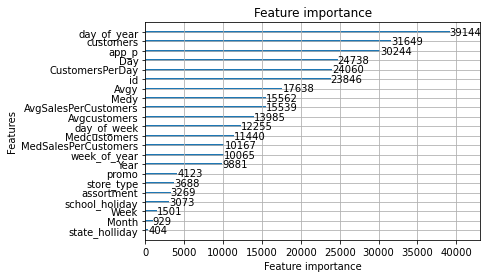

In [483]:
lgb.plot_importance(base_lgb_model)

In [484]:
features = build_features(test_df, store_df)
display(features)

test_preds = base_lgb_model.predict(features[X])

test_preds

<ipython-input-473-a12169c1d938>:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  merged['Week'] = pd.to_datetime(merged['date']).dt.week


,id,date,customers,open,promo,state_holliday,school_holiday,y,day_of_week,day_of_year,week_of_year,mean,median,Value_Average_Past_7_days,ratio_by_day_of_week,CustomersPerDay,app_p,Medy,Medcustomers,MedSalesPerCustomers,Avgy,Avgcustomers,AvgSalesPerCustomers,store_type,assortment,promo_interval,Year,Month,Day,Week
0,1105,2013-01-01,0,0,0,1,1,0,1,1,1,4385.796296,4044.0,0.0,8.886458,53302,0.000000,3789.0,456.0,8.649640,3743.856011,420.239102,8.738227,2,2,1,2013,1,1,1
1,306,2013-01-01,0,0,0,1,1,0,1,1,1,4549.681818,4395.0,0.0,9.355798,42794,0.000000,4066.0,455.0,9.175141,3594.572864,385.365159,9.279793,0,0,2,2013,1,1,1
2,1115,2013-01-01,0,0,0,1,1,0,1,1,1,5850.425926,5759.5,0.0,14.573775,43355,0.000000,5671.0,400.0,14.405091,5191.963514,357.147297,14.393107,3,2,3,2013,1,1,1
3,506,2013-01-01,0,0,0,1,1,0,1,1,1,7642.980198,7331.0,0.0,9.022218,85560,0.000000,6315.0,772.0,8.736083,6202.934871,693.701493,8.831728,0,0,1,2013,1,1,1
4,877,2013-01-01,0,0,0,1,1,0,1,1,1,6685.594828,6695.0,0.0,7.372790,105188,0.000000,5821.0,835.0,7.123987,5445.226391,751.159120,7.186708,0,2,0,2013,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203437,728,2015-07-31,542,1,1,0,1,0,4,212,31,5339.584071,5585.0,0.0,11.468789,52610,6216.083748,4929.0,437.0,11.380417,4345.749674,379.346806,11.385672,3,0,2,2015,7,31,31
203438,323,2015-07-31,716,1,1,0,1,0,4,212,31,7087.971963,7420.0,0.0,11.870420,63891,8499.220673,6858.5,591.0,11.723355,6127.597333,514.998667,11.816177,3,2,1,2015,7,31,31
203439,912,2015-07-31,806,1,1,0,1,0,4,212,31,5383.701754,5387.0,0.0,7.555701,81229,6089.894644,5277.0,707.0,7.527741,4786.674113,630.688568,7.534853,2,2,0,2015,7,31,31
203440,276,2015-07-31,575,1,1,0,1,0,4,212,31,4178.513043,4456.0,0.0,7.808782,61537,4490.049482,3791.0,523.0,7.852140,3489.566013,443.942484,7.814523,0,0,3,2015,7,31,31


array([ -46.71930076,   42.12112154,   19.60005165, ..., 7189.90217793,
       4940.90659293, 7212.06835906])

### Bagging

In [268]:
regr = BaggingRegressor(base_estimator=base_lgb_model,
                       n_estimators=30, verbose = 1)

regr.fit(X1, y1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3231
[LightGBM] [Info] Number of data points in the train set: 813767, number of used features: 23
[LightGBM] [Info] Start training from score 5776.636978
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3231
[LightGBM] [Info] Number of data points in the train set: 813767, number of used features: 23
[LightGBM] [Info] Start training from score 5771.088640
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3230
[LightGBM] [Info] Number of data points in the train set: 813767, number of used features: 23
[LightGBM

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3232
[LightGBM] [Info] Number of data points in the train set: 813767, number of used features: 23
[LightGBM] [Info] Start training from score 5766.045907
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3231
[LightGBM] [Info] Number of data points in the train set: 813767, number of used features: 23
[LightGBM] [Info] Start training from score 5770.386181
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3231
[LightGBM] [Info] Number of data points in the train set: 813767, number of used features: 23
[LightGBM

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3232
[LightGBM] [Info] Number of data points in the train set: 813767, number of used features: 23
[LightGBM] [Info] Start training from score 5778.742044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3233
[LightGBM] [Info] Number of data points in the train set: 813767, number of used features: 23
[LightGBM] [Info] Start training from score 5770.218073


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 124.9min finished


BaggingRegressor(base_estimator=LGBMRegressor(colsample_bytree=0.8,
                                              learning_rate=0.12, max_depth=15,
                                              min_child_weight=0.008,
                                              n_estimators=4900, num_leaves=65,
                                              reg_alpha=0.1, reg_lambda=1,
                                              subsample=0.8, verbose=1),
                 n_estimators=50, verbose=1)

In [269]:
features = build_features(test_df, store_df)

test_preds = regr.predict(features[X])

test_preds #Score 204,67

<ipython-input-241-7fb8fb43d66a>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  merged['Week'] = pd.to_datetime(merged['date']).dt.week
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 38.7min finished


array([ -21.7132843 ,   24.48782299,   22.4575506 , ..., 7120.22870684,
       4954.99075502, 7157.6003615 ])

## Stacking Models

In [ ]:
level0 = list()
level0.append(('xgboost', XGBRegressor(
    n_estimators = 140,
    eta = 0.1,
    max_depth = 17,
    min_child_weight = 4,
    subsample = 0.8,
    colsample_bytree = 0.8,
    tree_method = 'exact',
    reg_alpha = 0.06,
    random_state = 1043)))
level0.append(('RandomForest', RandomForestRegressor()))
# define meta learner model
level1 = LinearRegression()
# define the stacking ensemble
model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
model.fit(X1, y1)

In [ ]:
features = build_features(test_df, store_df)

test_preds = model.predict(features[X])

test_preds

## Error Observation

In [ ]:
y_pred = base_lgb_model.predict(X1)
X2 = X1
X2['abs_error'] = np.abs(y1-y_pred)
X2['y'], X2['y_pred'] = y1 , y_pred
X2 = X2.sort_values(by=['abs_error'], ascending=False)
#X2

In [ ]:
X2['ratio_actual'] = X2['y'] / X2['customers']

In [ ]:
X2.head(60)

In [ ]:
X2['abs_error'].describe()
#X2.boxplot(column='abs_error')

## Save as .csv

In [485]:
d = {'y': test_preds}
result = pd.DataFrame(data=d)
result.index.names = ['index']
result = result['y'].apply(lambda x: 0 if x<200 else x)
result

index
0            0.000000
1            0.000000
2            0.000000
3            0.000000
4            0.000000
             ...     
203437    7114.371014
203438    9321.204568
203439    7189.902178
203440    4940.906593
203441    7212.068359
Name: y, Length: 203442, dtype: float64

In [486]:
result.to_csv('solution.csv',encoding='ISO-8859-1', sep=',')